<a href="https://colab.research.google.com/github/disney-snoopy/SmArtGenerative/blob/master/notebooks/content_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Import

In [ ]:
#Adding new search path
!pip install git+https://github.com/disney-snoopy/toolbox
from toolbox.ntransfer import *

  Cloning https://github.com/disney-snoopy/toolbox to /tmp/pip-req-build-0cz36kx_
  Running command git clone -q https://github.com/disney-snoopy/toolbox /tmp/pip-req-build-0cz36kx_
  Created wheel for toolbox: filename=toolbox-1.0-cp37-none-any.whl size=2552 sha256=ab256beb6d7e679c35ff330c29e5952d4f539d56d34abdeff5065e832bd87b12
  Stored in directory: /tmp/pip-ephem-wheel-cache-h2eac31t/wheels/e0/e4/05/527fad3be42b4717820cf433a43a42d0fbdc7b4cee2cf8b4a7
Successfully built toolbox


In [ ]:
#Basic libraries
import matplotlib.pyplot as plt
import numpy as np

#torch libraries
import torch
from torchvision import models
from torch import nn
from torch import optim
import torch.nn.functional as F

#Custom libraries
#import loader
#from whitenoise import white_noise

In [ ]:
#Autoreload
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
#for gpu computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading images

In [ ]:
path_style = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/starry_night.jpg'
#path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/le_wagon.jpg'
#path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/boris_hanging.jpg'
path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/ocean_rock.jpg'

In [ ]:
#Loading and transforming pictures
tensor_style = loader(path_style).to(device, torch.float)
tensor_content = loader(path_content).to(device, torch.float)

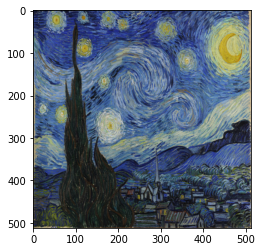

In [11]:
plt.imshow(tensor_style.cpu()[0].permute(1,2,0))

# Pretrained Model

In [ ]:
#Importing pretrained model
#features arguement returns only convolutional layers without classfier layers.
#eval() arguement ensures that all layers behaves as it should in evaluation/inference time.
vgg16 = models.vgg16(pretrained=True).features.eval().to(device)

In [ ]:
#List containing all layers of pretrained model.
layers = list(vgg16.children())

In [ ]:
#Printing layer details
layer_count = 0
for layer in layers:
  print('**************************')
  print(f'Layer count {layer_count}')
  print(layer)
  layer_count += 1

**************************
Layer count 0
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
**************************
Layer count 1
ReLU(inplace=True)
**************************
Layer count 2
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
**************************
Layer count 3
ReLU(inplace=True)
**************************
Layer count 4
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
**************************
Layer count 5
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
**************************
Layer count 6
ReLU(inplace=True)
**************************
Layer count 7
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
**************************
Layer count 8
ReLU(inplace=True)
**************************
Layer count 9
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
**************************
Layer count 10
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Extracting Content Feature maps

In [ ]:
class Extract_content(nn.Module):
  #Extract__nn class returns the feature maps of the first 5 conv layers of vgg16.
  def __init__(self):
    super(Extract_content, self).__init__()
    vgg16 = models.vgg16(pretrained=True).features.eval().to(device, torch.float)
    layers = list(vgg16.children())
    self.conv1 = layers[0]
    self.conv2 = layers[2]
    self.conv3 = layers[5]
    self.conv4 = layers[7]
    self.conv5 = layers[10]
    self.maxpool = layers[4]
  def forward(self, x):
    out1 = self.conv1(x)
    out1 = F.relu(out1)
    out2 = self.conv2(out1)
    out2 = F.relu(out2)
    out3 = self.maxpool(out2)
    out3 = self.conv3(out3)
    out3 = F.relu(out3)
    out4 = self.conv4(out3)
    out4 = F.relu(out4)
    out5 = self.maxpool(out4)
    out5 = self.conv5(out5)
    out5 = F.relu(out5)
    f_maps = [out1, out2, out3, out4, out5]
    return f_maps

In [ ]:
#Extracting feature maps
extract_model = Extract_content()
f_maps = extract_model(tensor_content)

In [ ]:
#Channel count per feature map
for f_map in f_maps:
  print(f_map.shape[1])

64
64
128
128
256


In [ ]:
def vis_fmap(f_map):
  #Plotting feature maps for inspection.
  row_count = int(np.ceil(f_map.shape[1]/8))
  fig, axs = plt.subplots(row_count, 8, figsize = (12, 12/(8/row_count)))
  axs = axs.flatten()
  for idx, ax in enumerate(axs):
    img = unloader(f_map[:, idx, :, :])
    ax.imshow(img, cmap = 'gray')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
  plt.subplots_adjust(wspace=0, hspace=0)

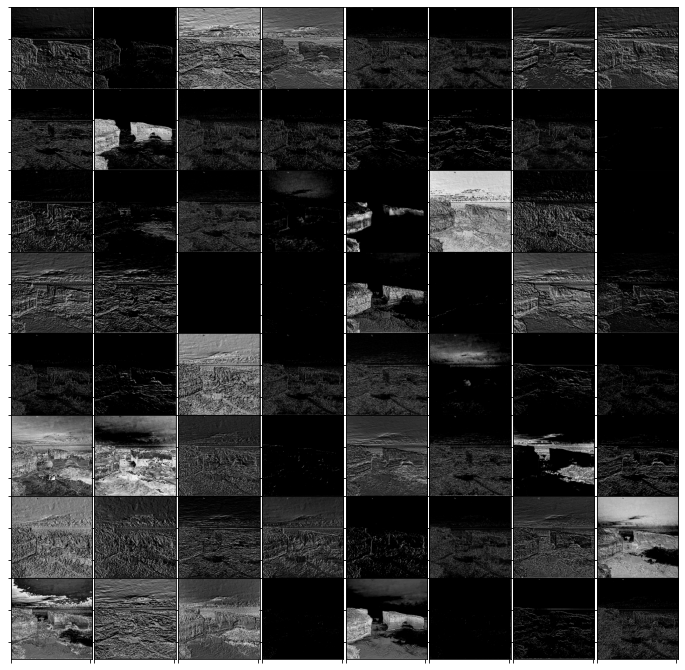

In [ ]:
vis_fmap(f_maps[1])

# Whitenoise image
Whitenoise image is used as a baseline image.

In [ ]:
tensor_noise = white_noise(512)

In [ ]:
loader.unloader(tensor_noise)

# Constructing a model using pretrained layers

In [ ]:
def model_construct(layer_count):
  vgg16 = models.vgg16(pretrained=True).features.eval()
  layers = list(vgg16.children())
  model = nn.Sequential()
  counter = 0
  for i in range(layer_count):
    layer_name = f'layer_{counter}'
    counter += 1
    model.add_module(layer_name, layers[i])
  return model.to(device)

In [ ]:
#Layer counts to recreate the model that produced each feature map
layer_counts = [2, 4, 7, 9, 12]

In [ ]:
def content_reconstruct(tensor_content, f_map, layer_count, img_start = None, imsize = 512, epochs = 50000, lr = 5e-4, stop_criterion = 0.9):
  #Deleting computational graph of feature maps.
  f_map = f_map.detach()
  #Creating whitenoise image as a starting template
  if img_start == None:
    img_start = white_noise(imsize).to(device, torch.float).requires_grad_()
  #Using MSE loss
  criterion = nn.MSELoss()
  #Using Adam as an optimiser
  opt = optim.Adam(params= [img_start], lr = lr)
  #Instantiating model with given layers from pretrained VGG16
  model = model_construct(layer_count)

  output = []
  stop_loss = 100

  for epoch in range(epochs):
    pred = model(img_start)
    loss = criterion(pred, f_map)

    loss.backward()
    opt.step()
    opt.zero_grad()
    if epoch % 1000 == 0:
      print(f'Epoch {epoch}, Loss: {loss}')
      output.append(img_start)
      if loss/stop_loss > stop_criterion:
        break
      stop_loss = loss
      
  return output

In [ ]:
recon = content_reconstruct(tensor_content, f_maps[0], 2)

In [ ]:
loader.unloader(recon[-1])

In [ ]:
recon2 = content_reconstruct(tensor_content, f_maps[1], 4)

In [ ]:
loader.unloader(recon2[0])

In [ ]:
recon3 = content_reconstruct(tensor_content, f_maps[-1], 12)

In [ ]:
loader.unloader(recon3[-1])